# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [12]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [15]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [16]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [17]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [18]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

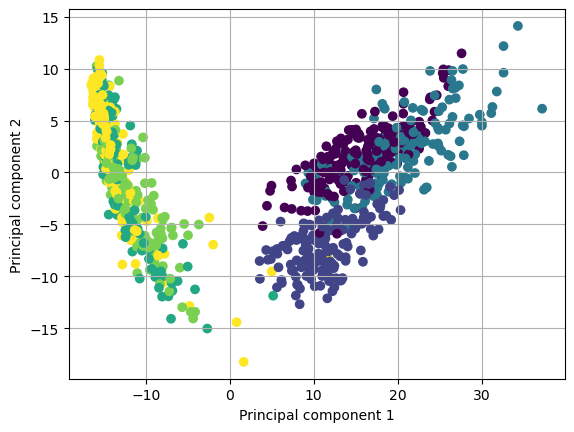

In [21]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

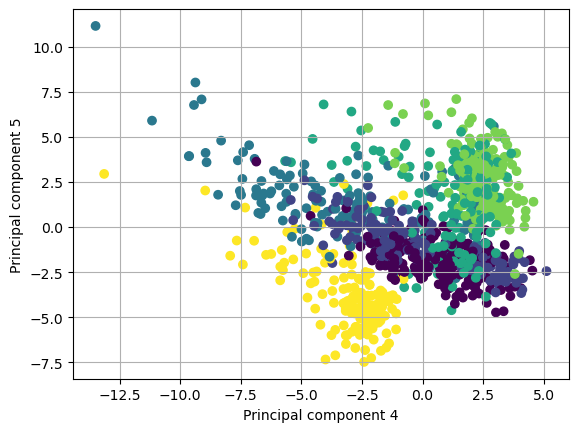

In [22]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [23]:
!pip install ucimlrepo

In [24]:
import ucimlrepo as uci

In [25]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [26]:
! pip install xgboost scikit-learn

In [46]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

# Define a few sets of hyperparameters to test

# Я использовал xgboost.

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

hparams = [
    {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'sample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'eta': 0.05,
        'objective': 'multi:softmax',
        'num_class': 7
    },
    {
        'n_estimators': 200,
        'learning_rate': 0.01,
        'max_depth': 3,
        'min_child_weight': 5,
        'sample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 0.5,
        'eta': 0.05,
        'objective': 'multi:softmax',
        'num_class': 7
    },
    {
        'n_estimators': 500,
        'learning_rate': 0.3,
        'max_depth': 7,
        'min_child_weight': 10,
        'sample': 1.0,
        'colsample_bytree': 1.0,
        'gamma': 0.2,
        'reg_alpha': 0,
        'reg_lambda': 0,
        'eta': 0.05,
        'objective': 'multi:softmax',
        'num_class': 7
    }
]

for i, params in enumerate(hparams):
    print(f"Model {i} Accuracy: {accuracy_score(y_test, xgb.train(params, xgb.DMatrix(X_train_pca, label=y_train), 100).predict(xgb.DMatrix(X_test_pca, label=y_test)))}\n")

Model 0 Accuracy: 0.9063454360366474

Model 1 Accuracy: 0.8177807940278249

Model 2 Accuracy: 0.9104173736002714



## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [59]:
# YOUR CODE HERE
# Я использовал следующую документацию: https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html

import optuna

def objective(trial):
    optset = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'sample': trial.suggest_float('sample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'objective': 'multi:softmax',
        'num_class': 7
    }
    
    return 1.0 - accuracy_score(y_test, xgb.train(optset, xgb.DMatrix(X_train_pca, label = y_train), 100).predict(xgb.DMatrix(X_test_pca, label=y_test)))

study = optuna.create_study()
# Можно уменьшить количество trials, если не хотите долго ждать.
study.optimize(objective, n_trials = 50)

bestTrial = study.best_trial
print(f'ACCURACY: {1.0 - bestTrial.value}')

[I 2024-11-17 14:42:20,078] A new study created in memory with name: no-name-8274030b-a4d4-4378-bb61-ee517ac2f312
[I 2024-11-17 14:42:22,683] Trial 0 finished with value: 0.09501187648456055 and parameters: {'n_estimators': 440, 'learning_rate': 0.18808306162885066, 'max_depth': 7, 'min_child_weight': 2, 'sample': 0.5174269927752808, 'colsample_bytree': 0.7122977581417723, 'gamma': 0.3712357893959026, 'reg_alpha': 0.021409979328868147, 'reg_lambda': 0.8456291019307918, 'eta': 0.08257506495425479}. Best is trial 0 with value: 0.09501187648456055.
[I 2024-11-17 14:42:23,339] Trial 1 finished with value: 0.1917203936206312 and parameters: {'n_estimators': 109, 'learning_rate': 0.07679286305109093, 'max_depth': 1, 'min_child_weight': 2, 'sample': 0.7229081673523038, 'colsample_bytree': 0.8070845405994468, 'gamma': 0.26730458143368585, 'reg_alpha': 0.09168311917193232, 'reg_lambda': 0.5868040376878707, 'eta': 0.08514422670095076}. Best is trial 0 with value: 0.09501187648456055.
[I 2024-11-

[I 2024-11-17 14:43:04,532] Trial 19 finished with value: 0.10620970478452663 and parameters: {'n_estimators': 354, 'learning_rate': 0.15861699061734816, 'max_depth': 2, 'min_child_weight': 3, 'sample': 0.5866154163482042, 'colsample_bytree': 0.8042890451106683, 'gamma': 0.4993698266924452, 'reg_alpha': 0.016774920198645373, 'reg_lambda': 0.8167556293438349, 'eta': 0.051380124692271475}. Best is trial 11 with value: 0.07431286053613839.
[I 2024-11-17 14:43:06,808] Trial 20 finished with value: 0.08449270444519852 and parameters: {'n_estimators': 292, 'learning_rate': 0.2779508602293266, 'max_depth': 6, 'min_child_weight': 7, 'sample': 0.8123926881739476, 'colsample_bytree': 0.8878515025420998, 'gamma': 0.011356799381898599, 'reg_alpha': 0.0006182685931312602, 'reg_lambda': 0.08092075556874245, 'eta': 0.0755638496611453}. Best is trial 11 with value: 0.07431286053613839.
[I 2024-11-17 14:43:08,342] Trial 21 finished with value: 0.07600950118764849 and parameters: {'n_estimators': 386, '

[I 2024-11-17 14:43:36,814] Trial 38 finished with value: 0.08686800135731254 and parameters: {'n_estimators': 372, 'learning_rate': 0.10028963933635954, 'max_depth': 6, 'min_child_weight': 2, 'sample': 0.6042387729691631, 'colsample_bytree': 0.556835552383604, 'gamma': 0.20570706371077252, 'reg_alpha': 0.09344182134233639, 'reg_lambda': 0.11143380089737331, 'eta': 0.07494373245667899}. Best is trial 11 with value: 0.07431286053613839.
[I 2024-11-17 14:43:37,823] Trial 39 finished with value: 0.08483203257550054 and parameters: {'n_estimators': 399, 'learning_rate': 0.28304415268199506, 'max_depth': 2, 'min_child_weight': 6, 'sample': 0.6571969914556434, 'colsample_bytree': 0.6029613378853044, 'gamma': 0.04931355801382427, 'reg_alpha': 0.04851457881676076, 'reg_lambda': 0.4174133039537381, 'eta': 0.06648985412439908}. Best is trial 11 with value: 0.07431286053613839.
[I 2024-11-17 14:43:39,519] Trial 40 finished with value: 0.08042076688157451 and parameters: {'n_estimators': 272, 'lea

ACCURACY: 0.9256871394638616


### Conclusion

Please, write down your thoughts on the experiment results:

1) Подбирать вручную значения довольно долго, проще использовать optuna и количество trials.
2) Используя optuna, производительность модели увеличилась.

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [57]:
! pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/82/29/923869e92c74bf07ec2b9a52ad5ac67d4184c873ba33ada7d4584356463a/shap-0.46.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   -- ------------------------------------- 30.7/456.1 kB 1.4 MB/s eta 0:00:01
   ------ -------------------------------- 71.7/456.1 kB 787.7 kB/s eta 0:00:01
   ------------ --------------------------- 143.4/456.1 kB 1.2 MB/s eta 0:00:01
   --------------------- ------------------ 245.8/456.1 kB 1.5 MB/s eta 0:00:01
   ----------------------------- ---------- 337.9/456.1 kB 1.6 MB/s eta 0:00:01
   ------------------------------------- -- 430.1/456.1 kB 1.7 MB/s eta 0:00:01
   ------------------------------------- --

BEST PARAMS: {'n_estimators': 386, 'learning_rate': 0.28999939458321716, 'max_depth': 4, 'min_child_weight': 8, 'sample': 0.648958787115562, 'colsample_bytree': 0.5969875583740293, 'gamma': 0.005010494156875364, 'reg_alpha': 0.06570502024743091, 'reg_lambda': 0.2832288477016193, 'eta': 0.06991066824759952}


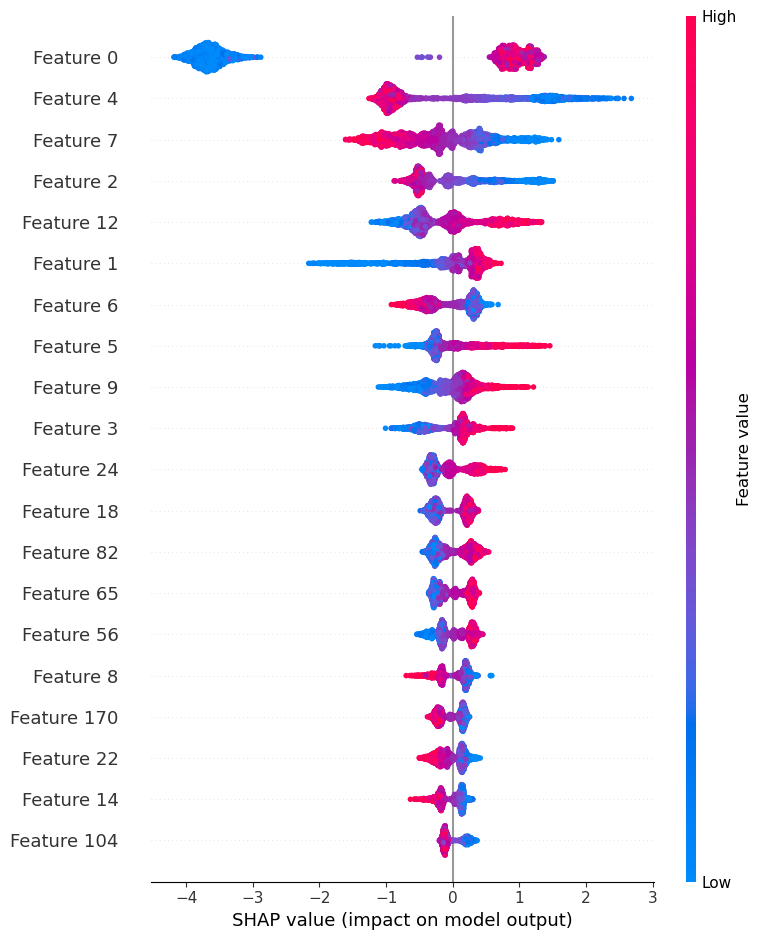

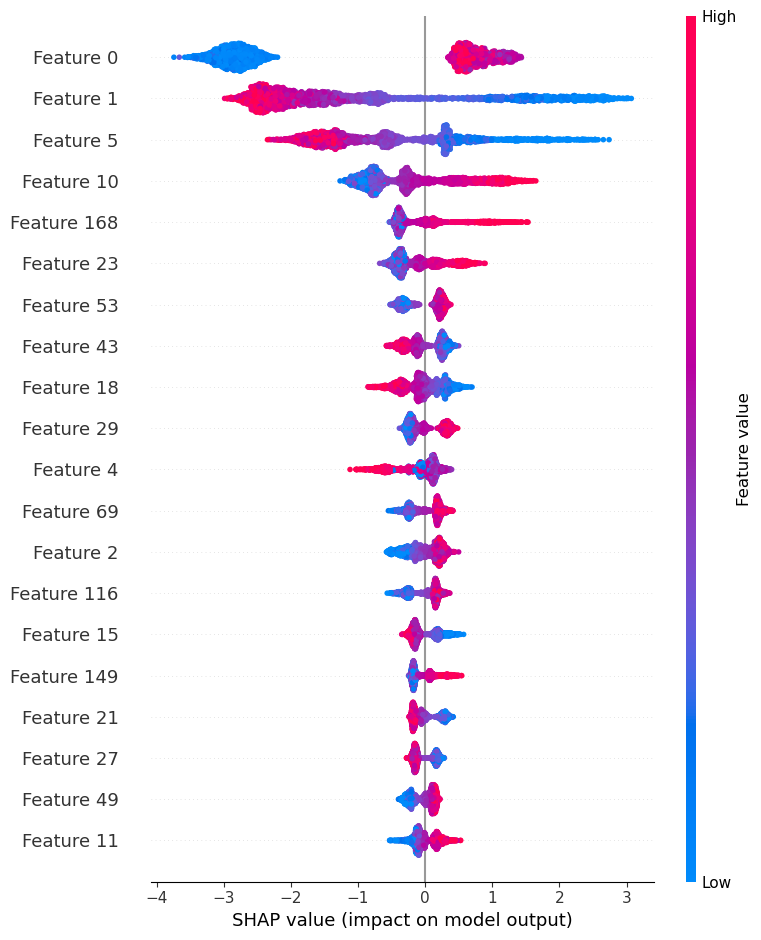

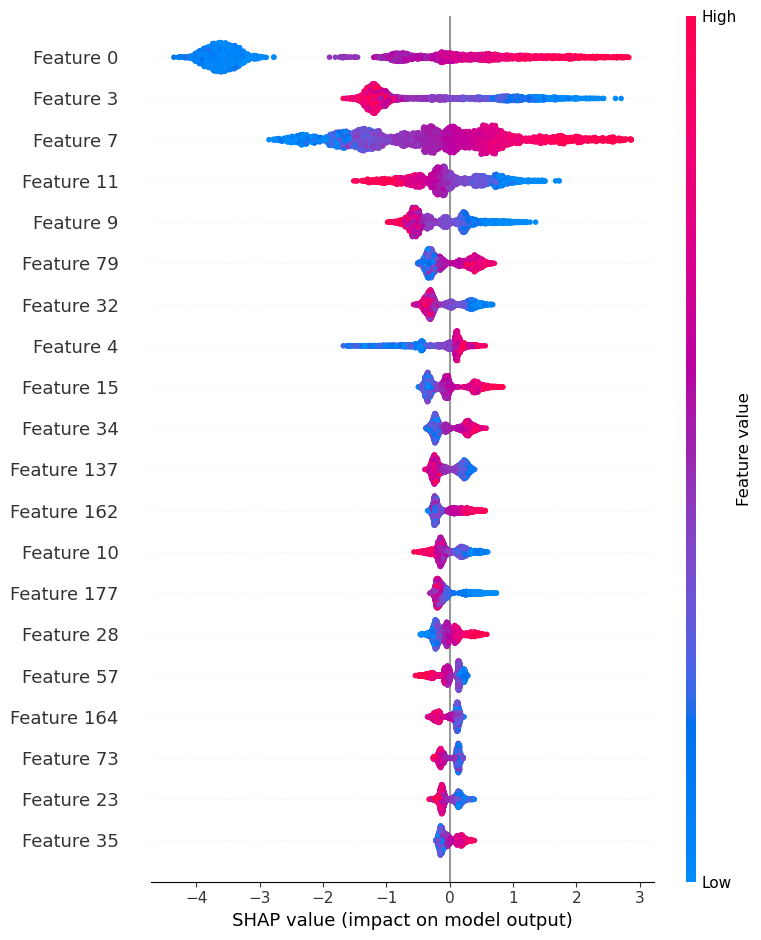

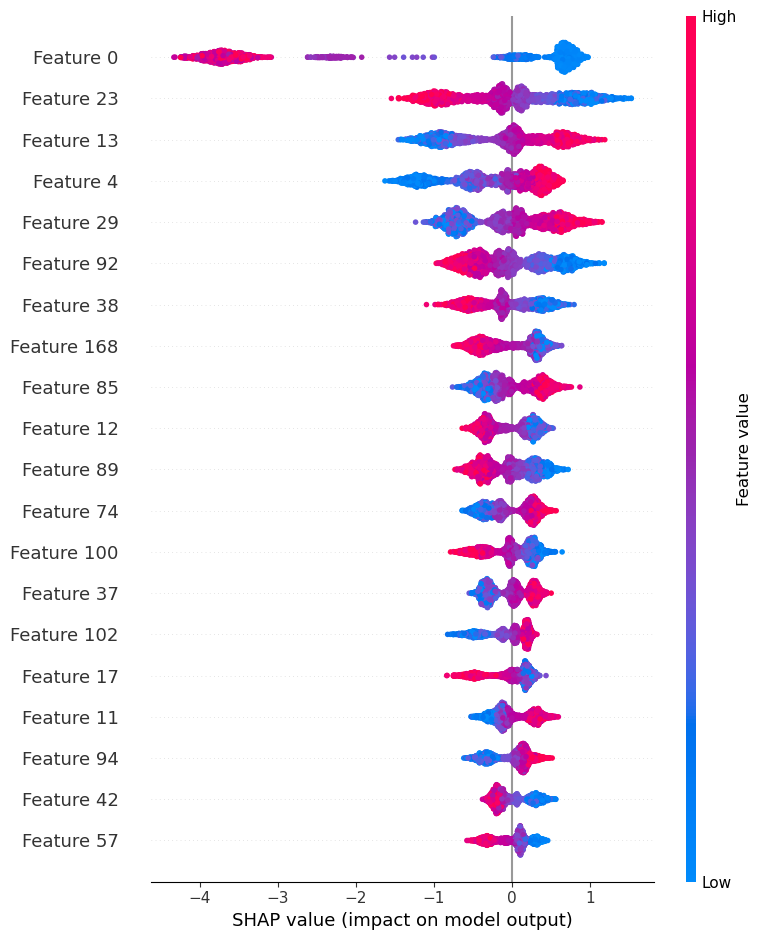

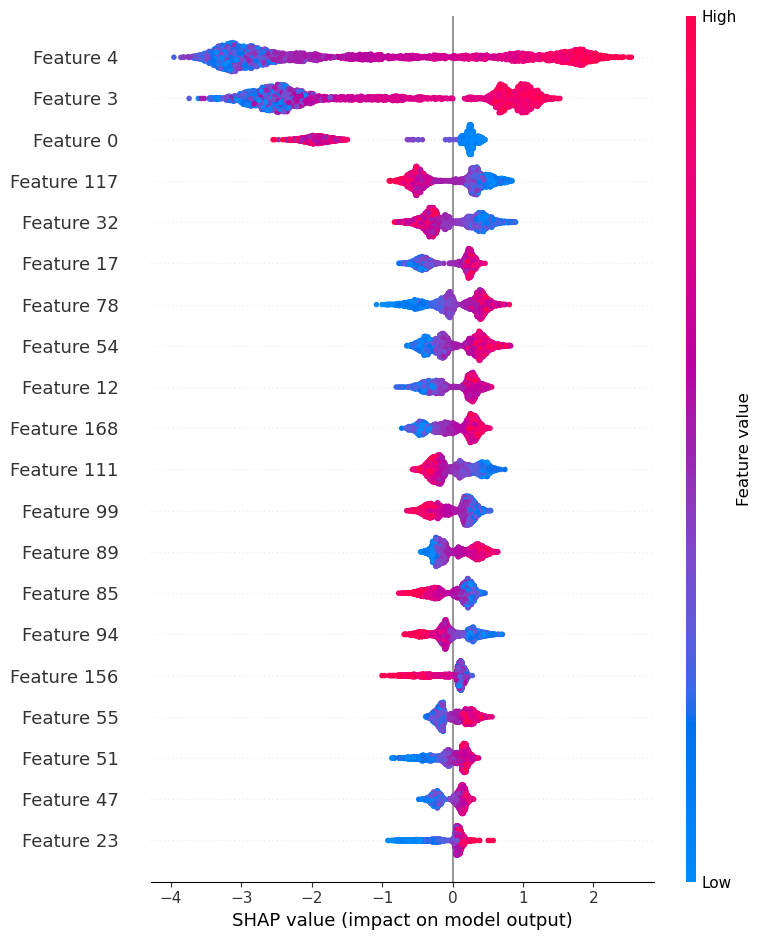

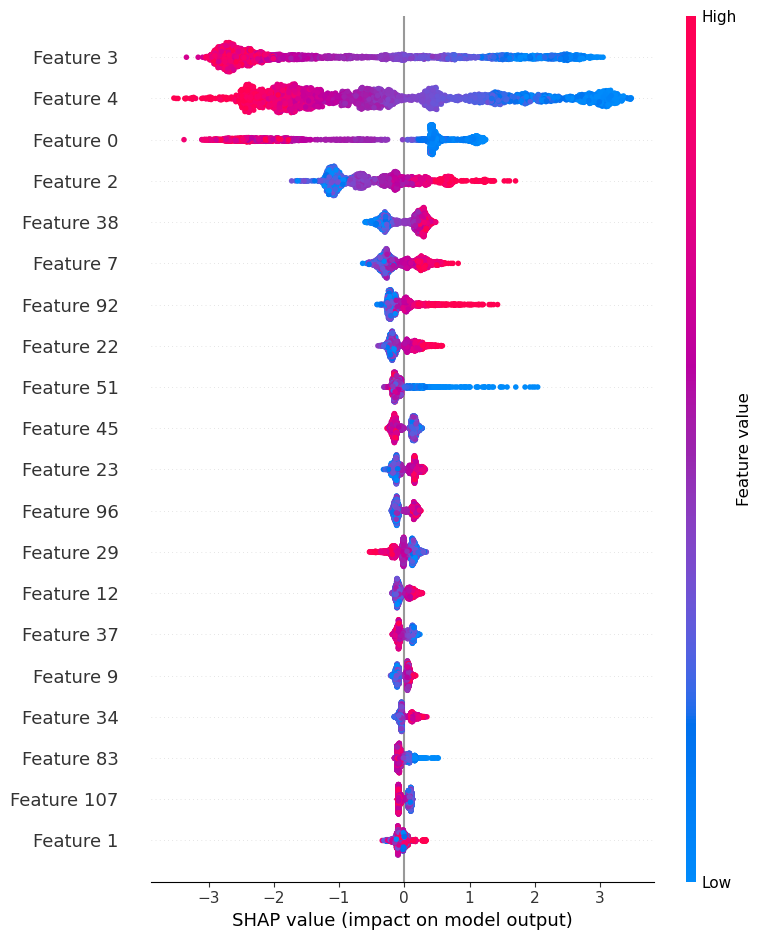

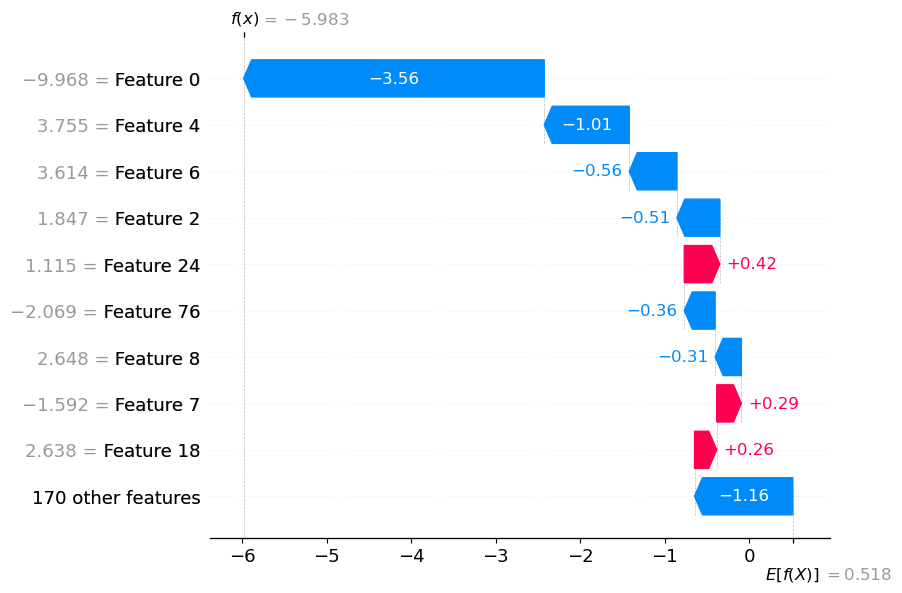

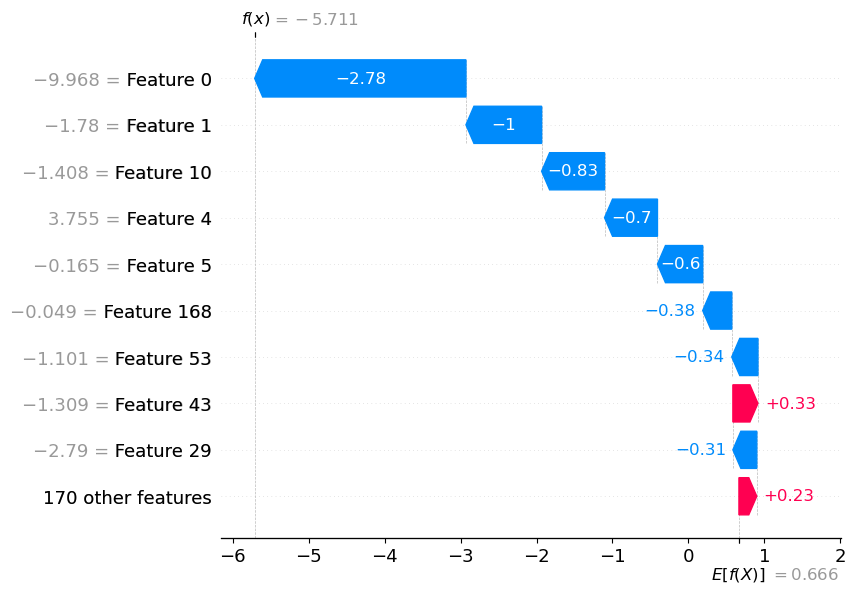

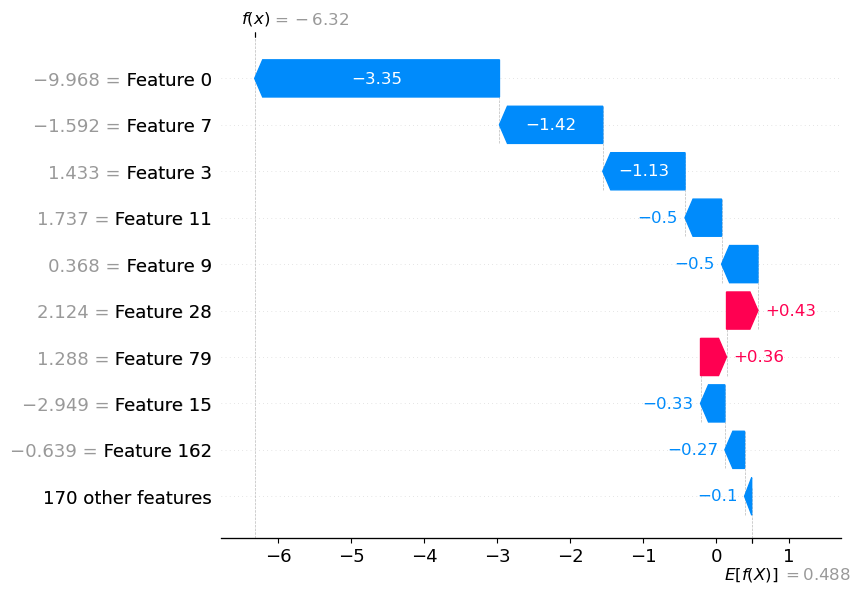

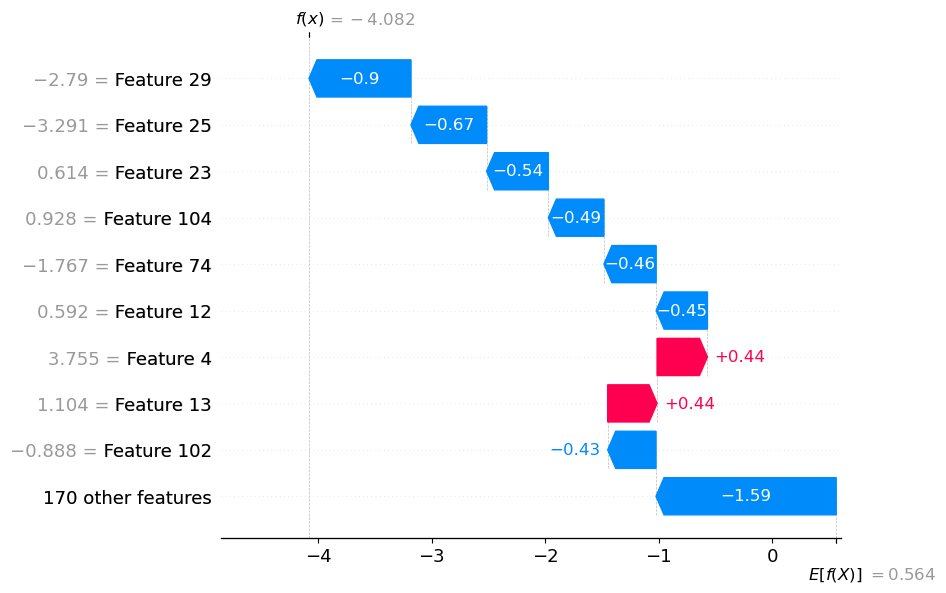

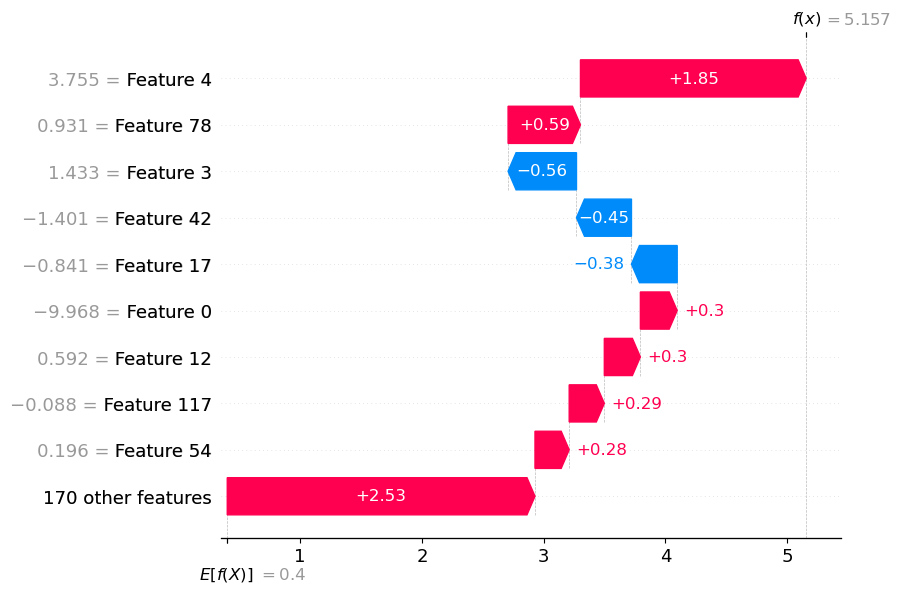

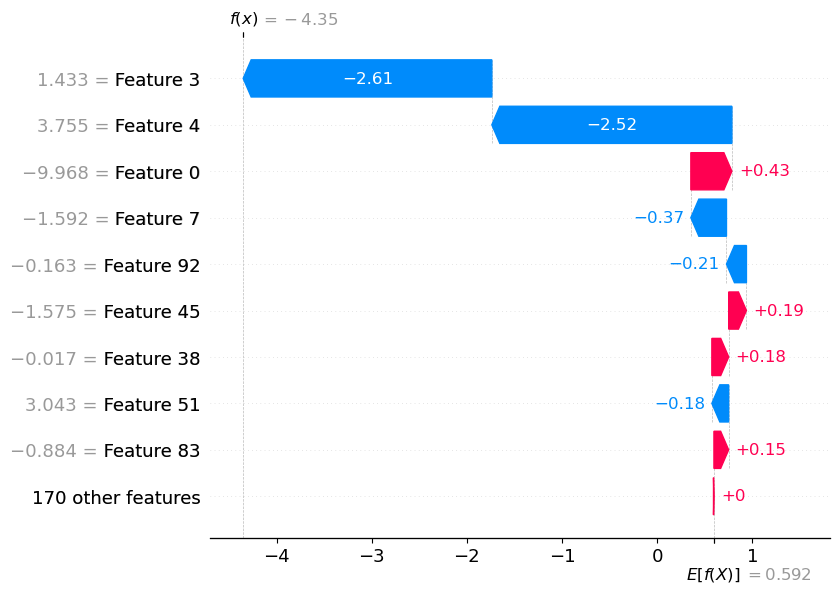

In [94]:
import shap  # noqa: F401


# YOUR CODE HERE
print(f'BEST PARAMS: {bestTrial.params}')

model = xgb.XGBClassifier(**bestTrial.params)
model.fit(X_train_pca, y_train)
vals = shap.Explainer(model)(X_test_pca)

for i in range(6):
    shap.summary_plot(vals[:, :, i], X_test_pca)
    
for i in range(6):
    shap.plots.waterfall(vals[0, :, i])

### Conclusion

Your thoughts about the plots and model behaviour:
Судя по графикам, можно заметить, какие главные компонены сильнее всего влияют на предикты модели.
В большинстве случаев - это первые главные компоненты.